# 量子変分線型ソルバー（Valiational Quantum Linear Solver）

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize

## 1. はじめに

線型変分量子ソルバー（Variational Quantum Linear Solver：VQLS）は、古典コンピューターよりも効率的に連立一次方程式を解くためにVQEを活用する変分量子アルゴリズムです。特に、 既知のベクトル$|\textbf{b}\rangle$ に対して、$\textbf{A} |\textbf{x}\rangle  =  |\textbf{b}\rangle$を満たす行列$\textbf{A}$が与えられたときに、VQLSアルゴリズムは理論的に、上記の関係式を満たすような$|\textbf{x}\rangle$に比例する規格化された$|x\rangle$を発見することができます。
  
このアルゴリズムの出力は、HHLアルゴリズムのものと同一で、HHLはVQLSよりもはるかにスピードアップが見込まれますが、VQLSはNISQ量子コンピューター上での稼働を可能にしている一方、HHLは多くの量子ビットを搭載していて、十分なエラー耐性が実現している量子ハードウェアを必要とします。


## 2. アルゴリズム

最初に、このアルゴリズムの入力は、複素係数で線型結合されたユニタリ行列に分解できる行列$\textbf{A}$とします。

$$A \ = \ \displaystyle\sum_{n} c_n \ A_n$$

各$A_n$はユニタリとして、状態$|0\rangle$から状態$|\textbf{b}\rangle$に遷移するユニタリ行列を$U$とします。ここで、変分量子アルゴリズムの一般的な構造を思い出してください。低深度のパラメーター化された量子回路で評価し、古典的オプティマイザーに出力するような、量子コスト関数を構成しなければいけません。これにより、$|\psi(\alpha)\rangle \ = \ \frac{|\textbf{x}\rangle}{|| \textbf{x} ||}$であるような、パラメーターセット$\alpha$をパラメーター空間から探すことができるようになります。ここで、 $|\psi(k)\rangle$ は、あるパラメーターセット$k$における量子回路の出力になります。 

実際のコスト関数を構成する前に、原論文に記載されている画像を元に、このアルゴリズムにおけるサブルーチンの俯瞰した概要を見てみましょう。

![alt text](images/bro.png)

各量子ビットが$|0\rangle$に初期化されている量子ビットレジスタから始めます。このアルゴリズムは、入力値を取り入れて、コスト関数を準備し、評価し、いくつかの補助量子ビット状態を生成します。計算したコストが、あるパラメーター$\gamma$よりも大きい場合、このアルゴリズムは、パラメーターを更新して再度実行します。そうでない場合は、アルゴリズムは処理を停止し、補助量子ビット状態は最適なパラメーターによって計算されます。これにより、コスト関数を最小化する状態ベクトルが得られ、$|\textbf{x}\rangle$の規格化したベクトルを得ることができます。<br>

## 3. Qiskitでの実装

### 固定ハードウェア補助量子ビット状態（Fixed Hardware Ansatz）
任意の状態$|\psi(k)\rangle$を用意する、補助量子ビット状態$V(\alpha)$を考えることから始めてみましょう。これによって、パラメーター$k$を変動させることによって状態空間を“探索”することができるようになります。では、今回の実装に使う補助量子ビット状態を次のように与えてみましょう。

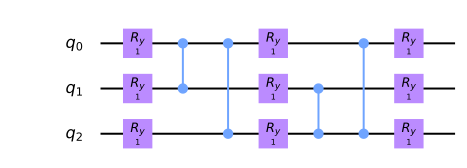

In [2]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw()

これは固定ハードウェア補助量子ビット状態（**fixed hardware ansatz**）と呼ばれます、量子ゲートの構成は、各実行において回路は同じであり、パラメーターが置き換わります。QAOAにおけるanstazとは異なり、トロッター化されたハミルトニアンでは構成されていません。$CZ$が異なる量子ビット間での\"干渉\"を起こす限り、$Ry$ゲートの応用によって、状態空間を探索できるようになります。

ここで、実際の**コスト関数**について考えてみましょう。このアルゴリズムの目的は、コストを最小化することです。つまり、$|\Phi\rangle  = \textbf{A} |\psi(k)\rangle$が $|\textbf{b}\rangle$に非常に近い時にはコスト関数の出力をとても小さくし、逆に直交するようなベクトルであった場合にはコスト関数を大きくするようにします。そこで、射影ハミルトニアンを導入します。

$$H_P \ = \ \mathbb{I} \ - \ |b\rangle \langle b|$$
    
これは次のような性質を持ちます。

$$C_P \ = \ \langle \Phi | H_P | \Phi \rangle \ = \ \langle \Phi | (\mathbb{I} \ - \ |b\rangle \langle b|) |\Phi \rangle \ = \ \langle \Phi | \Phi \rangle \ - \ \langle \Phi |b\rangle \langle b | \Phi \rangle$$
  
第2項目から、$|b\rangle$に沿った $|\Phi\rangle$の\"適合度\"がわかります。次に、これを別の数値から差し引いて、$|\Phi\rangle$と$|b\rangle$ の内積が大きい場合（より一致する場合）、望ましい低い数を取得します。これだけでもとても良く見えます。しかし、このアルゴリズムの正確性をさらに向上させることができる方法がもう一つあります。これは、$|\Phi\rangle$が小さいノルムを持つと、$|\textbf{b}\rangle$に一致していなくても、コスト関数が小さい値になってしまうという事実です。それゆえ、$|\Phi\rangle$を$\frac{|\Phi\rangle}{\sqrt{\langle \Phi | \Phi \rangle}}$に置き換えると次のようになります。

$$\hat{C}_P \ = \ \frac{\langle \Phi | \Phi \rangle}{\langle \Phi | \Phi \rangle} - \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{|\langle b | \Phi \rangle|^2}{\langle \Phi | \Phi \rangle}$$

これで、補助ビットによって$|\psi(k)\rangle$ を準備できました。ここから、コスト関数を計算するために、2つの値$|\langle b | \Phi \rangle|^2$と$\langle \Phi | \Phi \rangle$を求めていきます。幸運なことに、これらを計算するための量子サブルーチンとして、アダマールテストを使って計算することができます。本質的に、もし何らかのユニタリ演算子$U$と状態$|\phi\rangle$を持っていて、その状態に対する$U$の期待値 $\langle \phi | U | \phi \rangle$を求めたいとすると、その時、次の回路で見積ることができます。

<br><br>

![image1](images/h.png)

<br><br>

このとき、最初の量子ビットが$0$と測定される確率は$\frac{1}{2} (1 \ + \ \text{Re}\langle U \rangle)$であり、$1$と測定される確率は$\frac{1}{2} (1 \ - \ \text{Re}\langle U \rangle)$となり、この２つの確率の差を取ることで$\text{Re} \langle U \rangle$を得ます。幸運なことに、このテストで扱おうとしているこの行列は、この特定の実装において、全要素が実数の行列、つまり$\text{Re} \langle U \rangle \ = \ \langle U \rangle$です。これは、アダマールテストがどのように動くかを示したものです。回路図によると、一般の状態ベクトルは次のようになります。

<br>


$$\frac{|0\rangle \ + \ |1\rangle}{\sqrt{2}} \ \otimes \ |\psi\rangle \ = \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}}$$



<br>

制御ユニタリゲートを作用させると、次のようになります:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}}$$



<br>

最初の量子ビットにアダマールテストを作用させます:


<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{1}{2} \ \big[ |0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle \ + \ |0\rangle \ \otimes \ U|\psi\rangle \ - \ |1\rangle \ \otimes \ U|\psi\rangle \big]$$



<br>



$$\Rightarrow \ |0\rangle \ \otimes \ (\mathbb{I} \ + \ U)|\psi\rangle \ + \ |1\rangle \ \otimes \ (\mathbb{I} \ - \ U)|\psi\rangle$$



<br>

最初の量子ビットに測定を行うと、これが$0$を測定する確率を見つけることを思い出すと、その状態と$|0\rangle$の内積を計算しなければならず、その時にそれの複素共役（複素共役に慣れていない場合は、量子力学の章を確認してください。）をかけることになります。同じことを$1$の測定についても行います。それによって、次の式を得ます。 

<br>



$$P(0) \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I} \ + \ U) (\mathbb{I} \ + \ U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I}^2 \ + U \ + \ U^{\dagger} \ + \ U^{\dagger} U) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (2\mathbb{I} \ + U \ + \ U^{\dagger}) |\psi\rangle$$



<br>



$$\Rightarrow \ \frac{1}{4} \Big[ 2 \ + \ \langle \psi | U^{\dagger} | \psi \rangle \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{4} \Big[ 2 \ + \ (\langle \psi | U | \psi \rangle)^{*} \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{2} (1 \ + \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

同様の手順で、次の式を得ます:

<br>



$$P(1) \ = \ \frac{1}{2} \ (1 \ - \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

それから、差分を取ります:

<br>



$$P(0) \ - \ P(1) \ = \ \text{Re} \ \langle \psi | U | \psi \rangle$$



<br>

素晴らしい！今、我々は計算しなければならない２つの値についてこれを実装できました。$\langle \Phi | \Phi \rangle$から始めて、我々は次の式を得ます。

<br>



$$\langle \Phi | \Phi \rangle \ = \ \langle \psi(k) | A^{\dagger} A |\psi(k) \rangle \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} A V(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$



<br>



$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$



<br>


そして、アダマールテストを使うことで、いかなる項$\langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$を計算することができるようになりました。これによって、我々は状態$V(k) |0\rangle$を用意して、ユニタリ行列$A_m^{\dagger}$と$A_n$に対していくつかの制御補助量子ビットと共に制御演算を行います。これをコードで実装します。

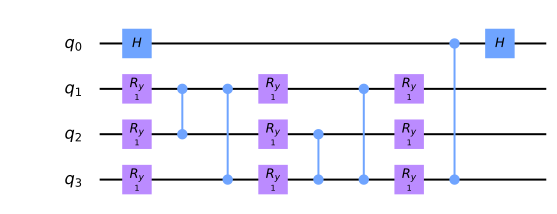

In [3]:
#アダマールテストを構成する

def had_test(gate_type, qubits, ancilla_index, parameters):

    circ.h(ancilla_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(ancilla_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(ancilla_index, qubits[ie])
    
    circ.h(ancilla_index)
    
circ = QuantumCircuit(4)
had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw()

我々が２つの異なるゲートタイプを適用しようとする理由は、これが$\langle \Phi | \Phi \rangle$の拡張形式の中に見れるゲートのペアを表現しているからです。
   
この実装の目的に注意しておくことも重要です。（実際に解く連立方程式は、ゲート$Z$と$\mathbb{I}$にだけ関心があり、したがってこれらのゲートのサポートのみを含みます。（そのコードでは、$0$に対する$\mathbb{I}$と$1$に対する$Z$)という異なるゲートの応用を意味する数字”識別子”を含みます。））
   
今、我々は計算すべき２つ目の値$|\langle b | \Phi \rangle|^2$に移ることができます。次の式を得ます。
 

<br>



$$|\langle b | \Phi \rangle|^2 \ = \ |\langle b | A V(k) | 0 \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(k) | 0 \rangle|^2 \ = \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

今しなければならないことは、積$\langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$に対して以前と同じ拡張です。
 

<br>



$$\langle 0 | U^{\dagger} A V(k) | 0 \rangle^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A_m^{\dagger} U |0\rangle$$



<br>

今再び、このデモの目的として、我々が実装した全ての出力/期待値が実数になることを見ることになります。つまり、次の式を得ます。
 
<br>



$$\Rightarrow \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \ = \ (\langle 0 | U^{\dagger} A V(k) | 0 \rangle)^{*} \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

故に、この特定の実装では

<br>



$$|\langle b | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$



<br>

新しく提案されたアダマールオーバーラップテスト（別紙参照）と呼ばれる方法を使って、この値を得るための洗練された方法がありますが、このチュートリアルではそれぞの行列を操作する標準的なアダマールテストのみを使っていきます。不幸なことに、これは補助量子ビットの使用が必要となります。我々は本質的に、補助量子ビット 事前準備したユニタリ$|b\rangle$とユニタリ $A_n$に関連する各ゲートに制御を配置します。
これで制御補助ビットに対してこれになるようなものを得られます。

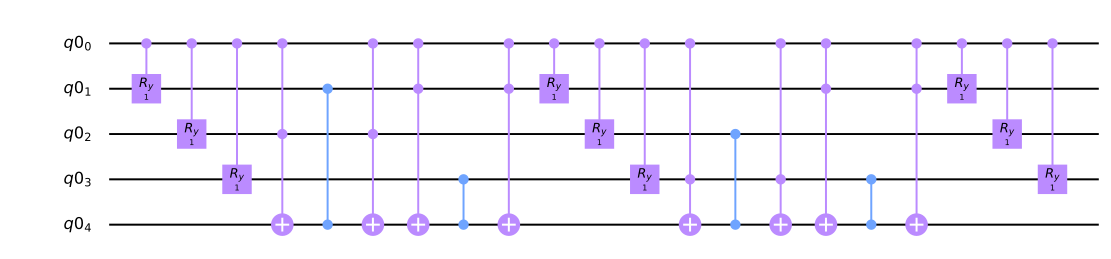

In [4]:
#アダマールテストで |<b|psi>|^2 を計算するための補助回路を構成する

def control_fixed_ansatz(qubits, parameters, ancilla, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, ancilla), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(ancilla, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(ancilla, qubits[1], 4)

    circ.ccx(ancilla, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(ancilla, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, ancilla), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(ancilla, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(ancilla, qubits[2], 4)

    circ.ccx(ancilla, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(ancilla, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, ancilla), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw()

外部量子ビット`q0_4`に注目してください。これは補助量子ビットであり、この回路にあるように$CCZ$ゲートを作れるようになます。今、我々も$U$も回路で作る必要があります。我々の実装では、$U$を次のように構成します。   

<br>



$$U \ = \ H_1 H_2 H_3$$



<br>

故に、我々は次の関数を作れます。

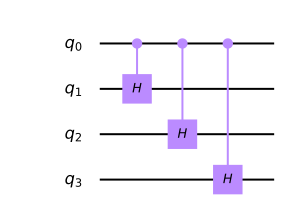

In [5]:
def control_b(ancilla, qubits):

    for ia in qubits:
        circ.ch(ancilla, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw()

最終的に、我々は新しいアダマールテストを構成します。

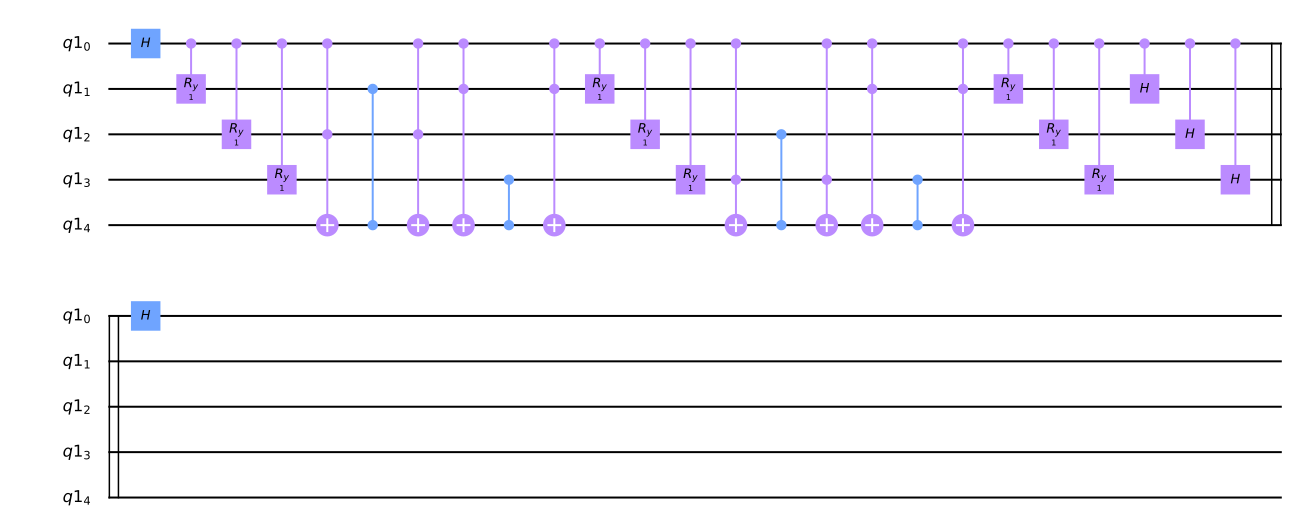

In [6]:
# <psi|psi>を計算する制御アダマールテストを構成する

def special_had_test(gate_type, qubits, ancilla_index, parameters, reg):

    circ.h(ancilla_index)

    control_fixed_ansatz(qubits, parameters, ancilla_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(ancilla_index, qubits[ty])


    control_b(ancilla_index, qubits)
    
    circ.h(ancilla_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
circ.draw()

これは、我々のパラメーターの全てが$1$に設定されたときの特別な実装であり、ゲート$A_n$の集合は単に`[0, 0, 0]`が全ての量子ビット上での恒等行列を作用させることに相当し、`[0, 0, 1]`が第３量子ビットに$Z$行列を作用させるものになります。（我々の"コード表記法"に従う）

さて、最終的なコスト関数を計算する準備ができました。これは単純に、異なる回路からの期待出力のすべての組み合わせの積を取り、それぞれの係数を掛け合わせて、前に説明したコスト関数に配置することを意味します!

In [7]:
#全体のコスト関数を実装する

def calculate_cost_function(parameters):
    
    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(5)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('statevector_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            job = execute(circ, backend)

            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('statevector_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                job = execute(circ, backend)

                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

このコードは長くて大変そうに見えますが、そんなことはありません！この状況では、数値的なアプローチを取っており、ここで、$1$状態にある補助量子ビットアダマール用量子ビットの測定に一致する各々の状態の振幅の2乗を計算し、この情報を元に$P(0) \ - \ P(1) \ = \ 1 \ - \ 2P(1)$を計算します。これは非常に正確ですが、（後でサンプリングについて議論しますが）現実の量子デバイスではこれらの確率を生成するために何度も回路のサンプリングを行わないといけないので、現実的ではありません。加えて、このコードは最適化されていません（必要以上に回路の評価を完成させています）。しかしこれが実装可能な最も簡単な方法であり、近い将来このチュートリアルを更新して最適化する予定です。
  
最後のステップは、実際にある一次方程式を解くことをこのコードを使って実施してみることです。まずは1つ例を見ていきましょう。

<br>



$$A \ = \ 0.45 Z_3 \ + \ 0.55 \mathbb{I}$$



<br>

コスト関数を最小化するために、COBYLA最適化手法を繰り返し使用していきます。パラメーターに対する我々の探査空間は初期ではランダムに選択される$\frac{k}{1000} (\ k \ \in \ \{0, \ 3000\} )$で決定されます。最適化された状態ベクトルを獲得するために、オプティマイザーを200ステップ実行し、そこで停止して最適なパラメーターに対して補助ビットを適用します。さらに、このアルゴリズムが実際に機能するかを確認するために、いくつかの後処理を計算します！これをするために、最適なベクトル$|\psi\rangle_o$に$A$を適用し、それを正規化し、このベクトルと回答ベクトル $|b\rangle$との内積の2乗を計算します。これを全てコードに書き下すと以下のようになります。

In [8]:
coefficient_set = [0.55, 0.45]
gate_set = [[0, 0, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

job = execute(circ, backend)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])
a3 = np.add(a1, a2)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.9525017762138146
0.9002309465052063
0.9988574465803983
0.8778546310899228
0.8521126645434376
0.7342613845729289
0.6992005098597478
0.8295512555275171
0.5383628551123725
0.5007402137107508
0.5303950779698489
0.48177662648062214
0.4668996272039816
0.5013393397068604
0.5875973530650762
0.4785598265522013
0.4564250518864408
0.5503144073290213
0.46522479966820396
0.44269218409937117
0.5203601994917957
0.4252389143259184
0.413774957713845
0.36491569912467536
0.417339648407528
0.3120194255855976
0.5046536616814559
0.30955446630759065
0.35602998901906757
0.38684673564326166
0.3686438203699881
0.3457315622901741
0.3266148284975623
0.2703767919694027
0.29408728867713896
0.25996900211358853
0.2582392620218944
0.2712592138413491
0.28653361757841933
0.2274645635024397
0.2781695310503891
0.2248501902082809
0.39162863215802757
0.22963862983759464
0.34240025731602386
0.21704976640581475
0.18208728685878306
0.18317967069649455
0.18330484782868162
0.11914293523651331
0.1146550011592431
0.0991218712641

見て取れるように、コスト関数は非常に小さい値`0.03273673575407443`を達成しています。そして古典的コスト関数計算すると、我々が測定したものと完全に一致するように `0.96776862579723`を得ます。ベクトル$|\psi\rangle_o$と$|b\rangle$はとても似ています。
    
別のテストやってみましょう。このとき、$|b\rangle$を同じにしておきますが、次のようにします。

<br>



$$A \ = \ 0.55 \mathbb{I} \ + \ 0.225 Z_2 \ + \ 0.225 Z_3$$



再び、最適化コードを実行します。

In [9]:
coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

job = execute(circ, backend)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

a3 = np.add(np.add(a2, a0), a1)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.9482467948093024
0.931662655030201
0.9919608169398847
0.7692175259201359
0.6554089518705122
0.9463789376935694
0.9226117896559509
0.7481466612528249
0.9504745377642584
0.7368907850330892
0.5566412602596771
0.5722304978103673
0.6820241981820887
0.6677450397760101
0.6114560463120735
0.4758351081268597
0.5322022004930328
0.6310459788960516
0.5576849675851256
0.45876037124621927
0.3010515008286023
0.30770225127728346
0.25624719885891367
0.23739221505700392
0.23881129552073566
0.17709826113713978
0.1503624461428794
0.08573865697495042
0.3309183854869837
0.22069059174712446
0.4289667012142423
0.17612102559714327
0.17426913064422977
0.18827940642589114
0.3071508208605317
0.12186988817985767
0.14282084533365857
0.17559057581986925
0.13416400973333253
0.11767192322610298
0.10894086121578817
0.1104167326208585
0.09215529100204278
0.0867950880015913
0.09411074924323715
0.06564067235443471
0.0585295495225191
0.05361180453219572
0.049290628923793434
0.04844826373988975
0.05144335253753263
0.04775

再び、`0.00014718223342624626`という非常に小さいエラーとなっており、古典的コスト関数は`0.9998563418983931`になっています。正常に動いています！
    
今、このアルゴリズムが**理論通り**動いていることがわかりました。数値的に確率を計算する代わりに回路をサンプリングしてある回路のシミュレーションをいくつか実行してみました。そこで、実際の量子コンピューターが動いているように、量子回路を**取り出して**みましょう！いくつかの理由により、このシミュレーションだけは、とんでもないショット（結果の確率分布を計算するために回路を実行する）数に対して、ほんの少し良く収束するでしょう。これは、量子回路をサンプリングする際のノイズ性（同じパラメータで測定しても、必ずしも同じ結果が得られるとは限らない）から、古典的なオプティマイザ（COBYLA）の限界に起因していることがほとんどだと考えられます。幸運なことに、SPSAのようなノイズのある関数に対して構築した他のオプティマイザーがあります。しかしこのチュートリアルではそこまで踏み込みません。$A$の2番目の値と同じ行列$U$のサンプリングをしてみましょう。

In [10]:
#Implements the entire cost function on the quantum circuit (sampling, 100000 shots)

def calculate_cost_function(parameters):

    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('qasm_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            circ.measure(0, 0)

            job = execute(circ, backend, shots=100000)

            result = job.result()
            outputstate = result.get_counts(circ)

            if ('1' in outputstate.keys()):
                m_sum = float(outputstate["1"])/100000
            else:
                m_sum = 0

            overall_sum_1+=multiply*(1-2*m_sum)

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(1)
                
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('qasm_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.measure(0, 0)

                job = execute(circ, backend, shots=100000)

                result = job.result()
                outputstate = result.get_counts(circ)

                if ('1' in outputstate.keys()):
                    m_sum = float(outputstate["1"])/100000
                else:
                    m_sum = 0

                mult = mult*(1-2*m_sum)
            
            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

In [11]:
coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

job = execute(circ, backend)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

a3 = np.add(np.add(a2, a0), a1)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.9514881256868424
0.9766254808002898
0.9849065022786203
0.9090483367060972
0.9935904637319564
0.8066815420560158
0.8557895142936941
0.975499199287233
0.8566190425582184
0.6630291044758974
0.7057849489667776
0.7766728975912867
0.7535717666281818
0.8454745001520697
0.6751125419970294
0.5685648065754553
0.48151004726056
0.27763085090977946
0.3218710656620408
0.2880017400357686
0.3047179907701498
0.2776975694790661
0.2588265798193674
0.2693031066723719
0.4405940346501014
0.25331076506719763
0.313613807713899
0.25875488934871305
0.26428160645312715
0.2512394256779028
0.223406832959258
0.22466529288002135
0.24275334363216927
0.229671217858612
0.2317579951097024
0.24926946114023807
0.23342087536524447
0.21839860348999252
0.22655420232480483
0.20634498281132663
0.20298312824190912
0.21484451514352976
0.20788496898369002
0.20362143592877624
0.2154262579422067
0.2147662884924697
0.2117111685060976
0.2098764963417985
0.21945140819975673
0.20556269749621603
0.20520800555336027
0.21468097224978266

見てきたように、驚くことなく、この解法はまだかなりのマージンで外れています。（$3.677\%$エラーは酷くはありませんが、しかし理想的には、**より**0に近づけていこうとしています。）さらに、これは実際の量子回路が原因であったわけではなく、オプティマイザー自身のせいだと考えれます。この問題（先ほど述べたように、ノイズありオプティマイザーの導入のように）を正す方法を理解してから、このノートブックを更新していきます。
   

## 4. 謝辞

この実装は、[研究論文\"Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems\", written by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles](https://arxiv.org/abs/1909.05820) で述べられる内容を元にしています。
    

論文に関する私の質問に答えてくれたカルロス・ブラボ＝プリエト氏に特別な感謝の意を表したいと思います。

In [12]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}